<a href="https://colab.research.google.com/github/ddovidovich/DataScienceLerning/blob/main/UNIT_10_DZ_Ultra_Pro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Задание

Создайте автокодировщик, удаляющий черные квадраты в лучшайных областях изображений.

Алгоритм действий:
1. Возьмите базу картинок Mnist.
2. На картинках в случайных местах сделайте чёрные квадраты размера 8 на 8.
3. Создайте и обучите автокодировщик восстанавливать оригинальные изображения из "зашумленных" квадратом изображений.
4. Добейтесь MSE < 0.0070 на тестовой выборке

## Импорт библиотек

In [2]:
# Отображение
import matplotlib.pyplot as plt

# Для работы с тензорами
import numpy as np 

# Класс создания модели
from tensorflow.keras.models import Model

# Для загрузки данных
from tensorflow.keras.datasets import mnist

# Необходимые слои
from tensorflow.keras.layers import Input, Conv2DTranspose, MaxPooling2D, Conv2D, BatchNormalization

# Оптимизатор
from tensorflow.keras.optimizers import Adam

## Данные

In [3]:
# Загрузка данных
(X_train, y_train), (X_test, y_test) = mnist.load_data() 

11490434/11490434 [==============================] - 0s 0us/step


In [4]:
# Нормировка данных
X_train = X_train.astype('float32')/255.
X_test = X_test.astype('float32')/255.

In [5]:
# Изменение формы под удобную для Keras
X_train = X_train.reshape((-1, 28, 28, 1))
X_test = X_test.reshape((-1, 28, 28, 1))

In [23]:
# Ваше решение
# Проверка формы данных
print(X_train.shape)
print(X_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [7]:
# Функция последовательного вывода нескольких изображений для сравнения
def plot_images(x_data, pred, n=5): 

    plt.figure(figsize=(14, 7))                     # Размер полотна

    for i in range(1, n + 1):                              # Повтор n раз:
        index = np.random.randint(0, pred.shape[0]) # Выбор случайного индекса 

        # Показ картинки с индексом index из набора x_data
        ax = plt.subplot(2, n, i)               # Картинка располагается в верхнем ряду
        plt.imshow(x_data[index].squeeze(), cmap='gray')
        ax.get_xaxis().set_visible(False) 
        ax.get_yaxis().set_visible(False) 

        # Показ картинки с тем же индексом из предсказания автокодировщика
        ax = plt.subplot(2, n, i + n)           # Картинка располагается в нижнем ряду
        plt.imshow(pred[index].squeeze(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

In [8]:
# Функция сборки сверточного автокодировщика
def create_base_ae(in_shape):
    # Энкодер, вход нейросети
    img_input = Input(in_shape)

    # Энкодер, первый блок
    # 1.1. Двумерная свертка
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(img_input) 
    # 1.2. Нормализация
    x = BatchNormalization()(x)
    # 1.3. Двумерная свертка
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x) 
    # 1.4. Нормализация
    x = BatchNormalization()(x)
    # 1.5. Снижение размерности и обобщение данных
    x = MaxPooling2D()(x)

    # Энкодер, второй блок
    # 2.1. Двумерная свертка
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x) 
    # 2.2. Нормализация
    x = BatchNormalization()(x)
    # 2.3. Двумерная свертка
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    # 2.4. Нормализация
    x = BatchNormalization()(x)
    
    
    # На выходе кодировщика и на входе декодировщика z - вектор латентного пространства
    # 2.5. Снижение размерности и обобщение данных
    z = MaxPooling2D()(x)
        

    # Декодер, первый блок
    # 1.1. Транспонированная свертка - повышение размерности данных
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', activation='relu')(z)
    # 1.2. Нормализация
    x = BatchNormalization()(x) 
    # 1.3. Двумерная свертка
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    # 1.4. Нормализация
    x = BatchNormalization()(x) 
    # 1.5. Двумерная свертка
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    # 1.6. Нормализация
    x = BatchNormalization()(x)

    # Декодер, второй блок
    # 2.1. Транспонированная свертка - повышение размерности данных
    x = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same', activation='relu')(x) 
    # 2.2. Нормализация
    x = BatchNormalization()(x) # слой нормализации данных
    # 2.3. Двумерная свертка
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x) 
    # 2.4. Нормализация
    x = BatchNormalization()(x) # слой нормализации данных
    # 2.5. Двумерная свертка
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x) 
    # 2.6. Нормализация
    x = BatchNormalization()(x) 

    # Декодер, финальный слой двумерной свертки, выдающий итоговое изображение
    outputs = Conv2D(in_shape[-1], (3, 3), activation='sigmoid', padding='same')(x)

    # Сборка модели, на входе оригинальное изображение, на выходе - сжатое-восстановленное
    model = Model(inputs=img_input, outputs=outputs) 

    # Компиляция сети, назначение оптимизатора Adam + среднеквадратическая ошибка
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse') 

    # Возврат готовой модели
    return model 

In [9]:
# Сборка автокодировщика для формы картинок датасета
ae_mnist = create_base_ae(X_train.shape[1:])

In [10]:
# Сводка архитектуры автокодировщика
ae_mnist.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 28, 28, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0     

In [11]:
ae_mnist.fit(X_train, X_train, 
          epochs=50,
          batch_size=128,
          validation_data = (X_test, X_test))

Epoch 1/50
469/469 [==============================] - 23s 28ms/step - loss: 0.0399 - val_loss: 0.0134
Epoch 2/50
469/469 [==============================] - 13s 27ms/step - loss: 0.0075 - val_loss: 0.0054
Epoch 3/50
469/469 [==============================] - 13s 27ms/step - loss: 0.0047 - val_loss: 0.0040
Epoch 4/50
469/469 [==============================] - 12s 27ms/step - loss: 0.0035 - val_loss: 0.0030
Epoch 5/50
469/469 [==============================] - 13s 27ms/step - loss: 0.0028 - val_loss: 0.0024
Epoch 6/50
469/469 [==============================] - 13s 27ms/step - loss: 0.0023 - val_loss: 0.0026
Epoch 7/50
469/469 [==============================] - 13s 27ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 8/50
469/469 [==============================] - 13s 27ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 9/50
469/469 [==============================] - 13s 27ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 10/50
469/469 [==============================] - 13s 27ms/step - loss: 0.001

313/313 [==============================] - 1s 3ms/step


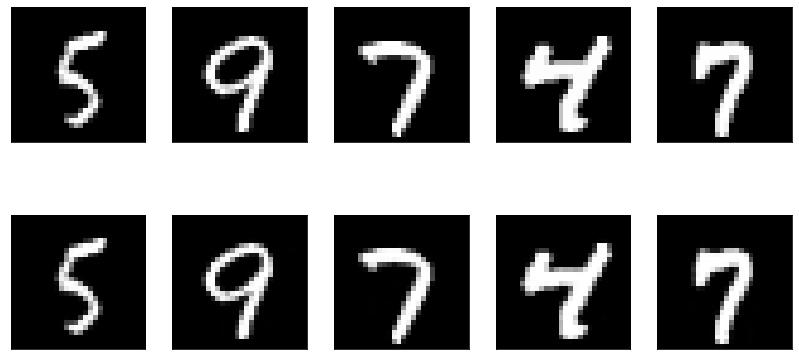

In [12]:
pred = ae_mnist.predict(X_test)
# Сравнение исходных и восстановленных картинок из тестовой выборки
plot_images(X_test,pred)

In [13]:
sq_test = X_test
sq_train = X_train

In [14]:
def add_square(x,xmax = 28,ymax = 28,sq_size = 8):
  x = x.copy()
  x_rnd = np.random.randint(0,(xmax - sq_size))
  y_rnd = np.random.randint(0,(xmax - sq_size))

  # Закрашивание черным пикселей в рамках квадрата
  for i in range(x_rnd,x_rnd+8):
    for j in range(y_rnd,y_rnd+8):
         x[i,j] = 0
         
  return x

In [15]:
sq_train = np.array(list(map(add_square, sq_train)))
sq_test = np.array(list(map(add_square, sq_test)))

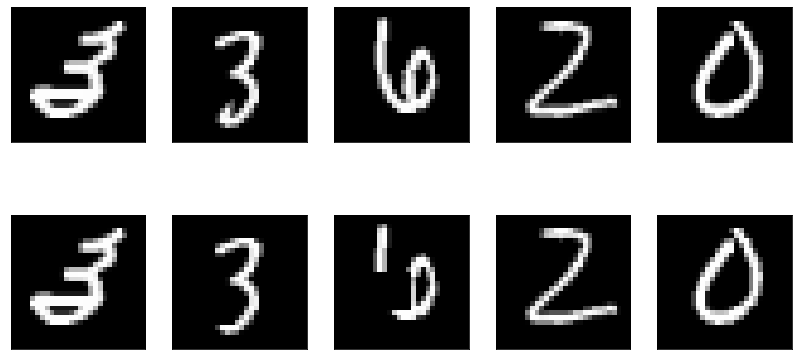

In [16]:
plot_images(X_test,sq_test)

In [17]:
history = ae_mnist.fit(sq_train, X_train, 
          epochs=50,
          batch_size=128,
          validation_data = (sq_test, X_test))

Epoch 1/50
469/469 [==============================] - 13s 27ms/step - loss: 0.0073 - val_loss: 0.0055
Epoch 2/50
469/469 [==============================] - 13s 27ms/step - loss: 0.0052 - val_loss: 0.0049
Epoch 3/50
469/469 [==============================] - 13s 27ms/step - loss: 0.0047 - val_loss: 0.0047
Epoch 4/50
469/469 [==============================] - 13s 27ms/step - loss: 0.0045 - val_loss: 0.0044
Epoch 5/50
469/469 [==============================] - 13s 27ms/step - loss: 0.0043 - val_loss: 0.0047
Epoch 6/50
469/469 [==============================] - 13s 27ms/step - loss: 0.0041 - val_loss: 0.0043
Epoch 7/50
469/469 [==============================] - 13s 27ms/step - loss: 0.0040 - val_loss: 0.0042
Epoch 8/50
469/469 [==============================] - 13s 27ms/step - loss: 0.0039 - val_loss: 0.0041
Epoch 9/50
469/469 [==============================] - 13s 27ms/step - loss: 0.0039 - val_loss: 0.0040
Epoch 10/50
469/469 [==============================] - 13s 27ms/step - loss: 0.003

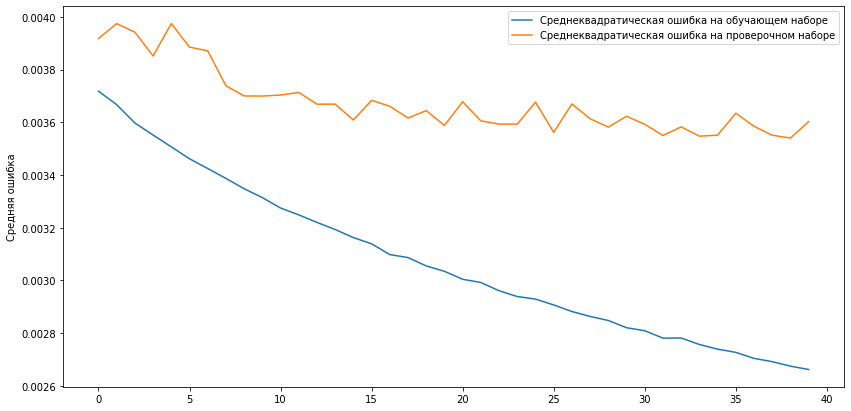

In [18]:
# Вывод графиков процесса обучения
plt.figure(figsize=(14,7))
plt.plot(history.history['loss'][10:], 
         label='Среднеквадратическая ошибка на обучающем наборе')
plt.plot(history.history['val_loss'][10:], 
         label='Среднеквадратическая ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

313/313 [==============================] - 1s 3ms/step


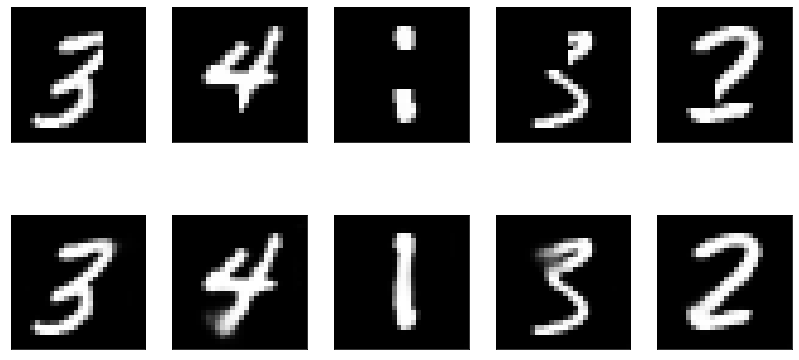

In [19]:
# Восстановление
pred = ae_mnist.predict(sq_test)

# Отображение результата
plot_images(sq_test, pred)

In [24]:
# Функция среднеквадратической ошибки для расчетов вручную
from sklearn.metrics import mean_squared_error

# Расчет количества пикселей изображения
image_size = X_train.shape[1] * X_train.shape[2]

# Расчет массивов среднеквадратических ошибок по всем картинкам тренировочной и тестовой выборок.
# mean_squared_error() ожидает двумерный вектор, для чего каждую картинку придется
# "сплющить" до одномерного вектора размера image_size
err_test_mnist = mean_squared_error(X_test.reshape(-1, image_size).T,
                                    pred.reshape(-1, image_size).T,
                                    multioutput='raw_values')

# Вывод средней ошибки
print(f'Средняя ошибка на  тестовом наборе MNIST: {err_test_mnist.mean()}')

Средняя ошибка на  тестовом наборе MNIST: 0.0036024944856762886


###Вывод

**Поставленная задача выполнена. Автокодировщик восстанавливает картинку из частично зашумленной (это хорошо видно на картинках). Требуемая точность (Добейтесь MSE < 0.0070 на тестовой выборке) тоже достигнута**